In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display

## 重新审视过拟合

## 扰动的稳健性

## 实践中的暂退法

## 从零开始实现

In [2]:
def dropout_layer(x, dropout):
    assert 0 <= dropout <= 1
    match dropout:
        case 0:
            return x
        case 1:
            return torch.zeros_like(x)
        case _:
            mask = (torch.rand(x.shape) < dropout).float()
            return mask * x/(1.0-dropout)

In [3]:
x = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(x)
print(dropout_layer(x, 0.))
print(dropout_layer(x, 0.5))
print(dropout_layer(x, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  8.,  0.,  0., 14.],
        [16.,  0., 20.,  0.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [5]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, x):
        H1 = self.relu(self.lin1(x.reshape(-1, self.num_inputs)))
        if self.training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout2)
        return self.lin3(H2)
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [6]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集, 然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True
    )
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
    )

In [7]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [8]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [9]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [10]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [12]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1,num_epochs], ylim=[0.3,0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (train_metrics + (test_acc,)))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

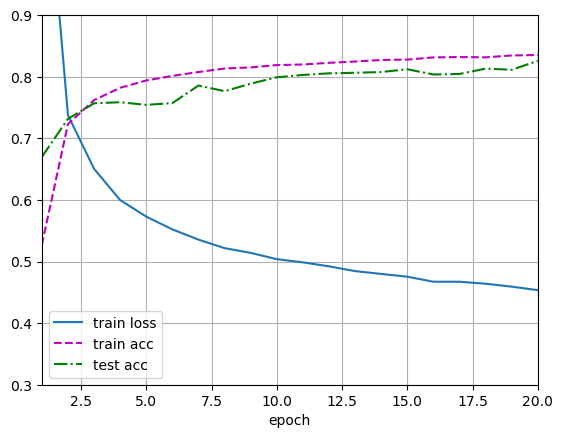

In [13]:
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

In [14]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(dropout2),
    nn.Linear(256, 10)
)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

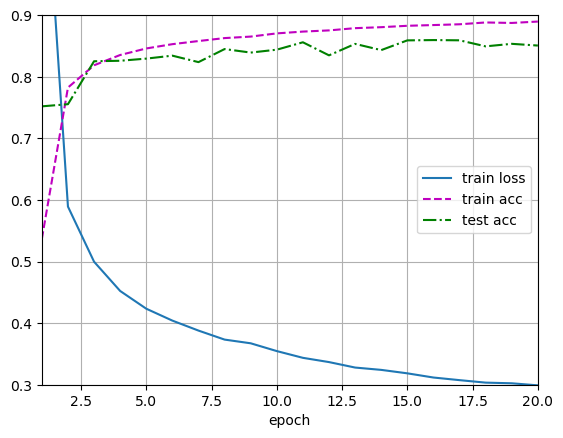

In [15]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, loss, num_epochs, trainer)

## Exercises

1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论

2. 增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较

3. 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的

4. 为什么在测试时通常不使用暂退法？

5. 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

6. 如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？

7. 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法